<a href="https://colab.research.google.com/github/srinath-96/SurvivalGuide101/blob/main/Survivor_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 376.2/376.2 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
pip install peft

In [3]:
from huggingface_hub import notebook_login

notebook_login()

In [4]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" huggingface_hub hf_transfer
    !pip install --no-deps unsloth

In [5]:
%%capture
# Install latest transformers for Gemma 3N
!pip install --no-deps --upgrade timm # Only for Gemma 3N

To authenticate with Hugging Face, you'll need an API token. If you don't have one, you can create one on the Hugging Face website under your profile settings.

Once you have your token, run the following cell and enter your token when prompted:

In [6]:
import json
from datasets import Dataset

def load_survival_dataset(data_file: str):
    """Load the formatted survival training data."""
    with open(data_file, 'r', encoding='utf-8') as f:
        training_data = json.load(f)
    return Dataset.from_list(training_data)
import glob
data_files = glob.glob("/content/drive/MyDrive/data/gemma3n_combined_training_20250719_212521.json")
latest_data_file = max(data_files)
dataset = load_survival_dataset(latest_data_file)
dataset = dataset.train_test_split(test_size=0.1, seed=42)
print(f"📈 Training examples: {len(dataset['train'])}")
print(f"🧪 Test examples: {len(dataset['test'])}")

📈 Training examples: 117
🧪 Test examples: 14


{'messages': [{'content': [{'source': None,
     'text': 'What natural resources in this image could be useful for survival?',
     'type': 'text'},
    {'source': {'data': '',
      'type': 'base64'},
     'text': None,
     'type': 'image'}],
   'role': 'user'},
  {'content': [{'source': None,
     'text': 'In this environment, several key survival considerations stand out. First, notice the available natural resources that could be useful: fallen branches, leaves, and natural formations. For shelter, you could use the natural formations for wind protection and construct a lean-to shelter. The terrain suggests that seasonal streams or collected rainwater might be available for water. Important safety considerations include weather exposure, wildlife activity, and terrain hazards. Remember to maintain awareness of your surroundings and preserve energy in this type of environment.',
     'type': 'text'}],
   'role': 'assistant'}],
 'system_prompt': 'You are an expert wilderness surviva
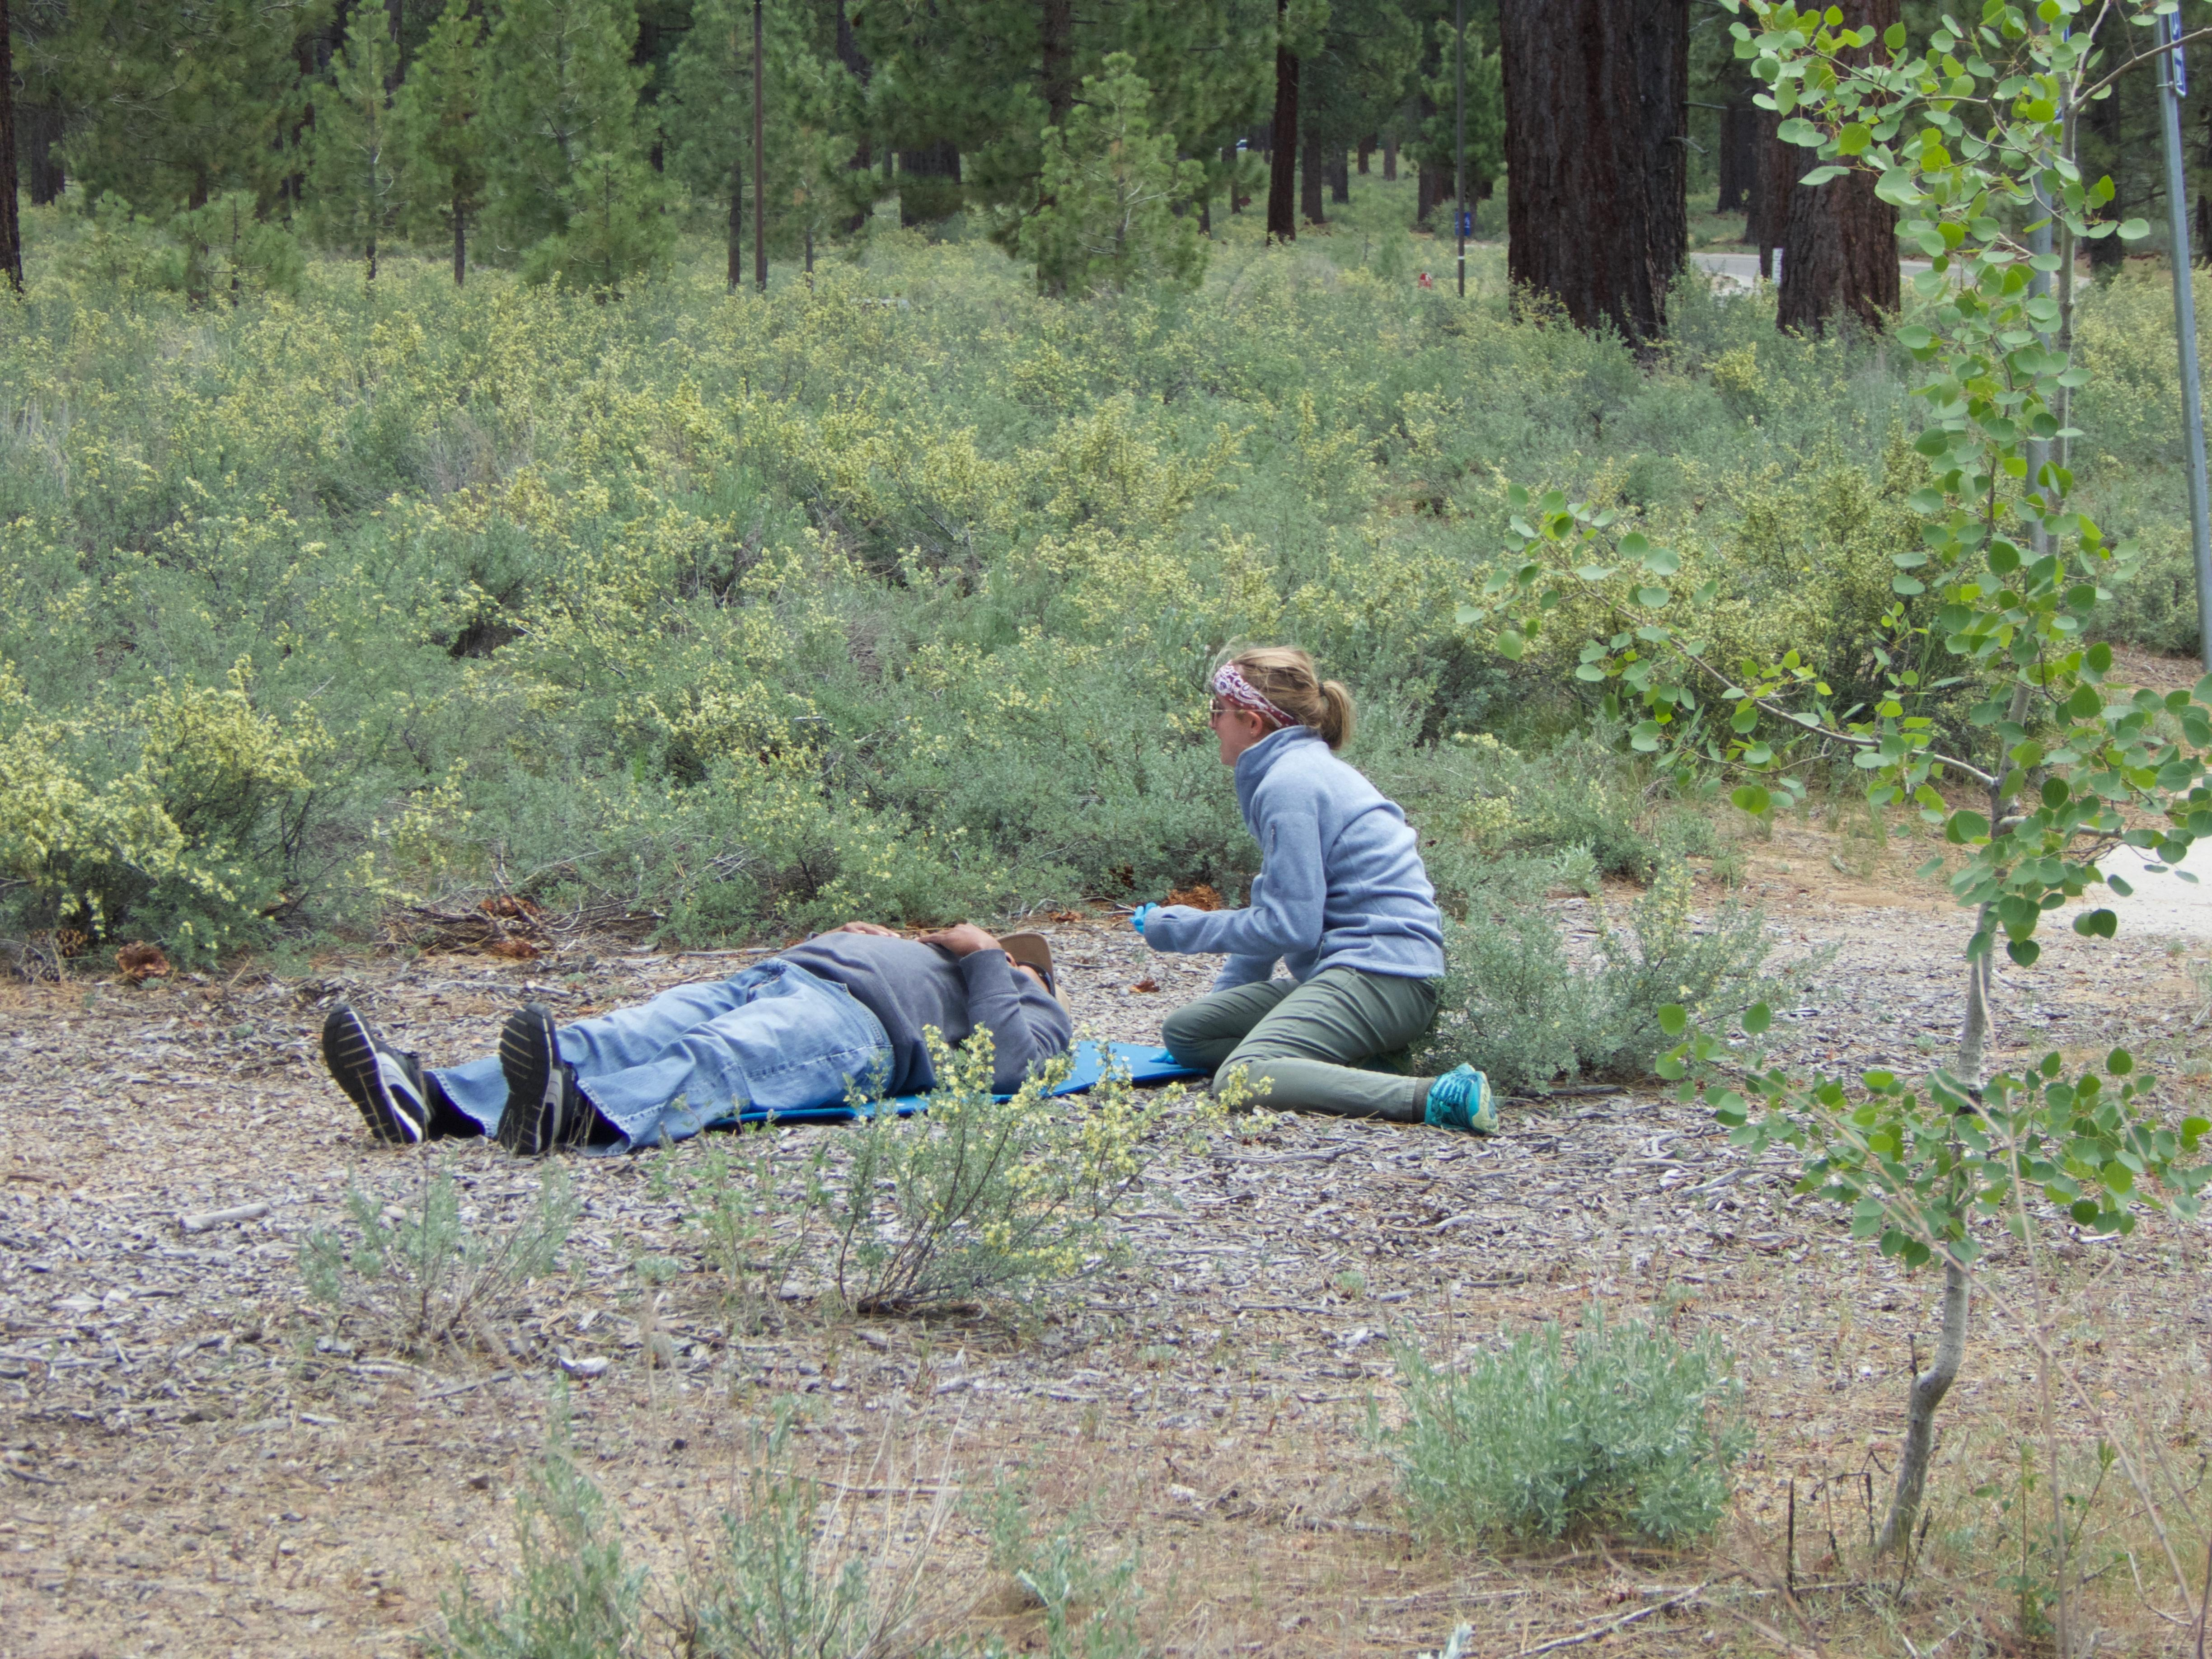

In [15]:
dataset['train'][1]


In [8]:
from unsloth import FastModel
import torch
from google.colab import userdata

model, tokenizer = FastModel.from_pretrained(
    model_name = "unsloth/gemma-3n-E2B-it",
    dtype = None, # None for auto detection
    max_seq_length = 1024, # Choose any for long context!
    load_in_4bit = True,  # 4 bit quantization to reduce memory
    full_finetuning = False, # [NEW!] We have full finetuning now!
    token = userdata.get('HF_TOKEN'), # use one if using gated models
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.7.5: Fast Gemma3N patching. Transformers: 4.53.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Gemma3N does not support SDPA - switching to eager!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/2.65G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/469M [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/98.0 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.70M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

In [9]:
from unsloth.chat_templates import get_chat_template
tokenizer = get_chat_template(
    tokenizer,
    chat_template = "gemma-3",
)

In [11]:
model = FastModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # Turn off for just text!
    finetune_language_layers   = True,  # Should leave on!
    finetune_attention_modules = True,  # Attention good for GRPO
    finetune_mlp_modules       = True,  # SHould leave on always!

    r = 8,           # Larger = higher accuracy, but might overfit
    lora_alpha = 8,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
)

Unsloth: Making `model.base_model.model.model.language_model` require gradients


In [16]:
def formatting_prompts_func(examples):
   convos = examples["messages"]
   texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False).removeprefix('<bos>') for convo in convos]
   return { "text" : texts, }

In [17]:
dataset = dataset.map(formatting_prompts_func, batched = True)

Map:   0%|          | 0/117 [00:00<?, ? examples/s]

Map:   0%|          | 0/14 [00:00<?, ? examples/s]

In [18]:
dataset['train'][100]["text"]

'<start_of_turn>user\nWhat are the steps to how to navigate without a compass?<end_of_turn>\n<start_of_turn>model\n2. Use the sun. If it\'s in the afternoon the sun will be setting so it will be, more or less, in the west. If it is still morning then it will be rising roughly in the east. You can then figure out the approximate directions of north and south as well. During midday it can be more difficult to determine which way the sun is moving, so you may need to work a little harder.\n4. Locate a flat, open area. Find a spot on the ground that is out of the shade. You will need direct sunlight in order to create a shadow. If you can find a patch of dirt, use that area instead of grass. The grass may make it more difficult to see the shadow accurately and mark it.\n6. Find a stick. It should be at least three feet tall.[1] X Research source Push the stick into the ground so it stands vertically. Place a stone or another stick on the tip of the shadow of the vertical stick. Wait for ha

In [19]:
from trl import SFTTrainer, SFTConfig
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset['train'],
    eval_dataset = dataset['test'], # Can set up evaluation!
    args = SFTConfig(
        dataset_text_field = "text",
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 4, # Use GA to mimic batch size!
        warmup_steps = 5,
        # num_train_epochs = 1, # Set this for 1 full training run.
        max_steps = 60,
        learning_rate = 2e-4, # Reduce to 2e-5 for long training runs
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        report_to = "none", # Use this for WandB etc
    ),
)

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/117 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/14 [00:00<?, ? examples/s]

In [20]:
from unsloth.chat_templates import train_on_responses_only
trainer = train_on_responses_only(
    trainer,
    instruction_part = "<start_of_turn>user\n",
    response_part = "<start_of_turn>model\n",
)

Map (num_proc=2):   0%|          | 0/117 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/14 [00:00<?, ? examples/s]

In [21]:
tokenizer.decode(trainer.train_dataset[100]["input_ids"])

"<bos><start_of_turn>user\nWhat are the steps to how to navigate without a compass?<end_of_turn>\n<start_of_turn>model\n2. Use the sun. If it's in the afternoon the sun will be setting so it will be, more or less, in the west. If it is still morning then it will be rising roughly in the east. You can then figure out the approximate directions of north and south as well. During midday it can be more difficult to determine which way the sun is moving, so you may need to work a little harder.\n4. Locate a flat, open area. Find a spot on the ground that is out of the shade. You will need direct sunlight in order to create a shadow. If you can find a patch of dirt, use that area instead of grass. The grass may make it more difficult to see the shadow accurately and mark it.\n6. Find a stick. It should be at least three feet tall.[1] X Research source Push the stick into the ground so it stands vertically. Place a stone or another stick on the tip of the shadow of the vertical stick. Wait fo

In [22]:
tokenizer.decode([tokenizer.pad_token_id if x == -100 else x for x in trainer.train_dataset[100]["labels"]]).replace(tokenizer.pad_token, " ")

"                     2. Use the sun. If it's in the afternoon the sun will be setting so it will be, more or less, in the west. If it is still morning then it will be rising roughly in the east. You can then figure out the approximate directions of north and south as well. During midday it can be more difficult to determine which way the sun is moving, so you may need to work a little harder.\n4. Locate a flat, open area. Find a spot on the ground that is out of the shade. You will need direct sunlight in order to create a shadow. If you can find a patch of dirt, use that area instead of grass. The grass may make it more difficult to see the shadow accurately and mark it.\n6. Find a stick. It should be at least three feet tall.[1] X Research source Push the stick into the ground so it stands vertically. Place a stone or another stick on the tip of the shadow of the vertical stick. Wait for half an hour.\n8. Check the location of the shadow. After about 20 minutes,[2] X Research source

In [23]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
10.988 GB of memory reserved.


In [24]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 117 | Num Epochs = 2 | Total steps = 60
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 4 x 1) = 4
 "-____-"     Trainable parameters = 10,567,680 of 5,450,005,952 (0.19% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
1,9.427100
2,5.738600
3,7.187000
4,9.085800
5,9.974200
6,9.131800
7,5.554700
8,6.114300
9,6.285900
10,8.678700


Unsloth: Will smartly offload gradients to save VRAM!


In [27]:
messages = [{
    "role": "user",
    "content": [{"type" : "text", "text" : "How do you disinfect a wound?",}]
}]
inputs = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
    tokenize = True,
    return_dict = True,
).to("cuda")

from transformers import TextStreamer
_ = model.generate(
    **inputs,
    max_new_tokens = 256, # Increase for longer outputs!
    # Recommended Gemma-3 settings!
    temperature = 1.0, top_p = 0.95, top_k = 64,
    streamer = TextStreamer(tokenizer, skip_prompt = True),
)

Okay, let's talk about how to disinfect a wound. It's really important to handle wounds properly to prevent infection. Here's a breakdown of the steps involved, along with important considerations:

**1. Assess the Wound**

*   **Severity:** Is it minor (a scratch or small cut) or serious (deep, bleeding, or signs of infection)?  Minor wounds are usually just cleaned. Serious wounds require medical attention.
*   **Bleeding:** If the wound is bleeding, apply direct pressure with a clean gauze pad or cloth until it stops.
*   **Signs of Infection:**  Look for these signs of infection:
    *   Increased pain
    *   Redness
    *   Swelling
    *   Pus or drainage
    *   Fever
    *   Red streaks spreading from the wound

**2. Clean the Wound**

*   **Wash Your Hands:** Before touching any wound, wash your hands thoroughly with soap and water for at least 20 seconds. This is the most important step to prevent infection.
*   **Rinse with Clean Water:** Gently rinse the wound with clean, 

# SAVING MODEL WEIGHTS TO HUGGINFACE


In [29]:
model.push_to_hub("srinath123/gemma-3", token = userdata.get('HF_TOKEN')) # Online saving
tokenizer.push_to_hub("srinath123/gemma-3", userdata.get('HF_TOKEN')) # Online saving

README.md:   0%|          | 0.00/607 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/42.3M [00:00<?, ?B/s]

Saved model to https://huggingface.co/srinath123/gemma-3


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.70M [00:00<?, ?B/s]